# ItalianSignNet study

### Importing Required Libraries

In [ ]:
#%pip install tf-keras
#%pip install lime scikit-image
#%pip install albumentations
#%pip install lime
#%pip install pyarrow
#%pip install seaborn
#%pip install mlflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 11.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 9.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.2/582.2 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 20.0.0
    Uninstalling pyarrow-20.0.0:
      Successfully uninstalled pyarrow-20.0.0━━━━━━━━━━━━━━━━━━━━━  3/32 [pyarrow]
  Attemptin

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
#import tf_keras as keras
import tensorflow.keras as keras
from PIL import Image
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import albumentations as A
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
#from keras.callbacks import LearningRateScheduler 
from keras.callbacks import ModelCheckpoint
import pickle
import glob
from sklearn.metrics import classification_report

import logging
logging.getLogger('lime').setLevel(logging.ERROR)

np.random.seed(42)

2025-06-07 13:09:51.261341: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 13:09:51.295039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 13:09:51.295081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 13:09:51.296386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 13:09:51.303591: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 13:09:51.304637: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import mlflow

def is_running_on_databricks():
    return os.environ.get("DATABRICKS_RUNTIME_VERSION") is not None

def configure_mlflow():
    if is_running_on_databricks():
        mlflow.set_tracking_uri("databricks")
        print("✅ MLflow → Databricks")
    else:
        mlflow.set_tracking_uri("http://mlflow:5000")
        print("✅ MLflow → locale")
        
configure_mlflow()
mlflow.set_experiment("traffic-signs-classification")


✅ MLflow → locale


<Experiment: artifact_location='/mlflow/mlflow_data/mlruns/1', creation_time=1749295058439, experiment_id='1', last_update_time=1749295058439, lifecycle_stage='active', name='traffic-signs-classification', tags={}>

### Boiterplate

In [3]:
DATA_DIR = '/workspace/src/dataset/artifacts/dataset_20250603_151956_eps_100'
TRAIN_PATH = f'{DATA_DIR}/train'
TEST_PATH = f'{DATA_DIR}/test'
VAL_PATH = f'{DATA_DIR}/validation'

IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30

# kaggle or docker kernel
WORSPACE_PATH = '/kaggle/working' if os.path.isdir('/kaggle/working') else '/workspace/src/models/notebook-workspace'

CLASSES = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

### Visualizing The Dataset

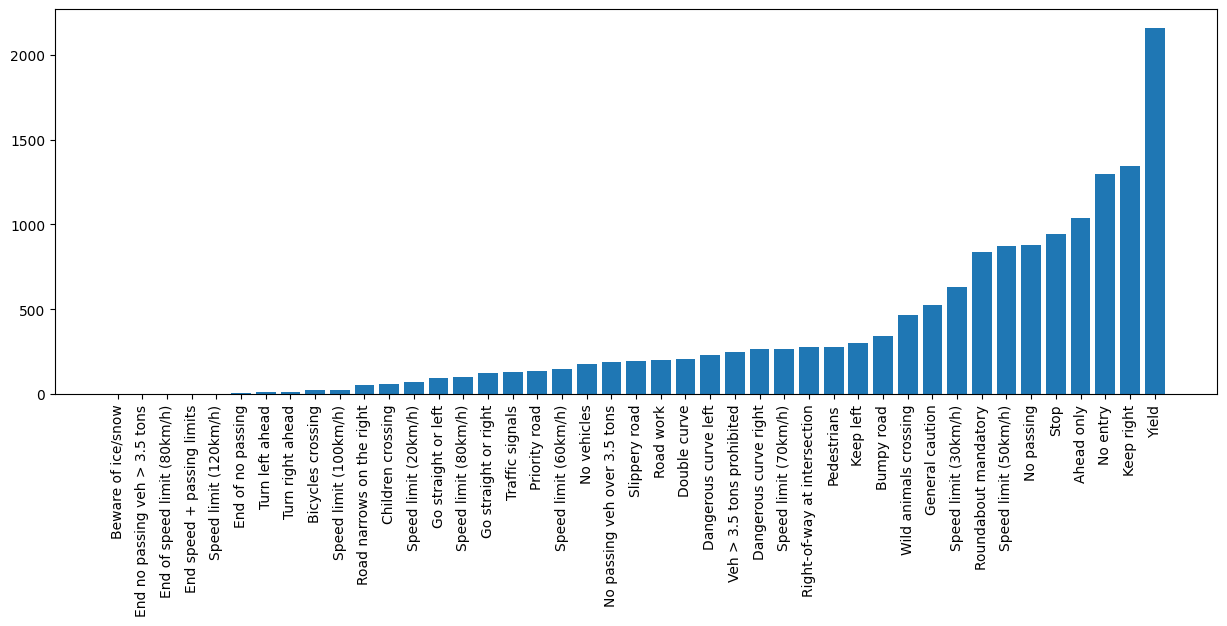

In [4]:
folders = os.listdir(TRAIN_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(CLASSES[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(15,5))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

### Albumentation visualitation

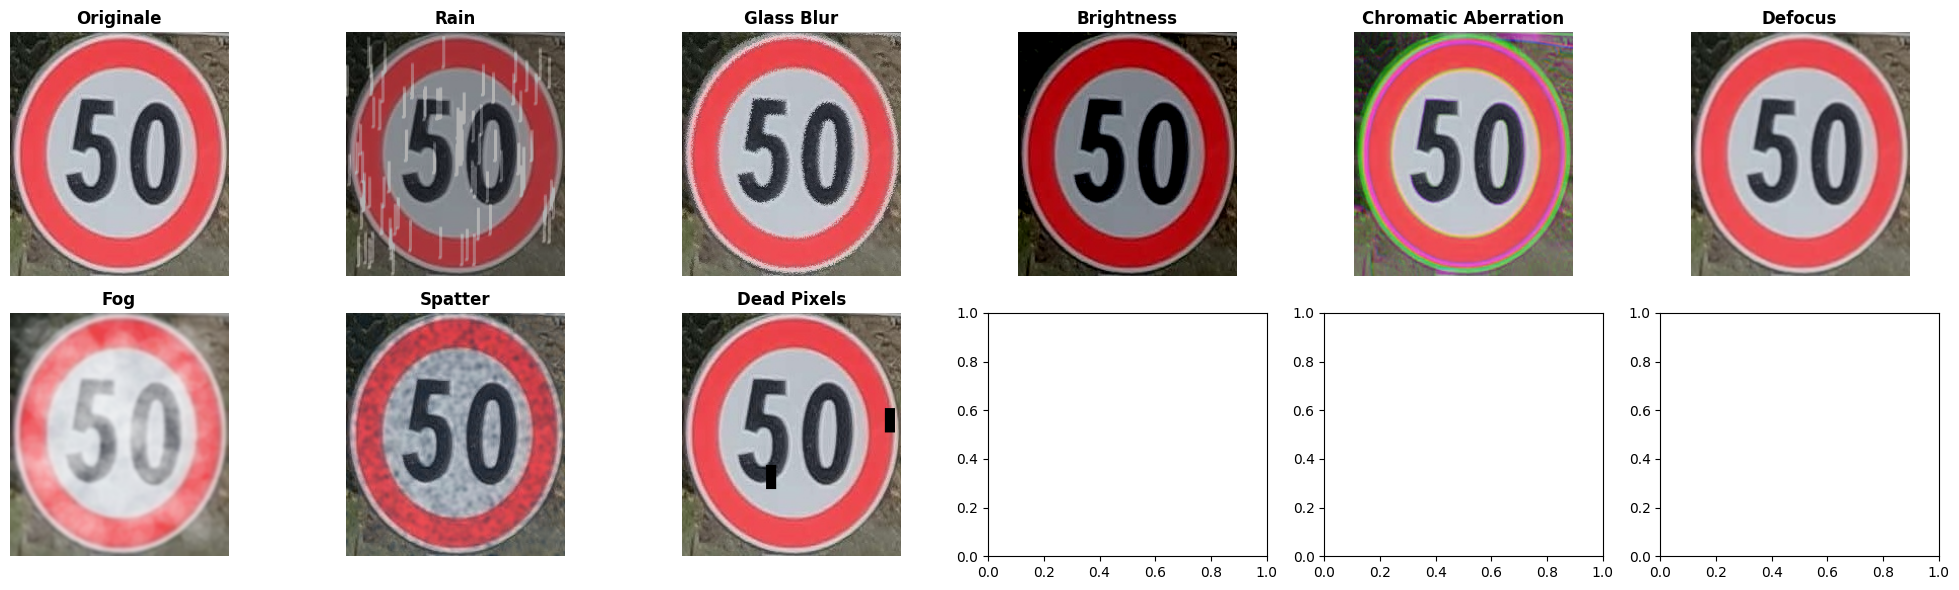

In [5]:
def show_albumentations_example(path):
    image_albumentations_example = cv2.imread(path)
    image_albumentations_example = cv2.cvtColor(image_albumentations_example, cv2.COLOR_BGR2RGB)

    transformations = [
        {"name": "Rain", "transform": A.RandomRain(
            slant_range=[-15, 15],
            drop_width=1,
            drop_color=[500, 500, 500],
            blur_value=3,
            brightness_coefficient=0.7,
            rain_type="default",
            p=1
        )},
        {"name": "Glass Blur", "transform": A.GlassBlur(
            sigma=0.2,
            max_delta=1,
            iterations=1,
            mode="fast",
            p=1
        )},
        {"name": "Brightness", "transform": A.RandomBrightnessContrast(
            brightness_limit=[-0.5, 0.2],
            contrast_limit=[-0.2, 0.2],
            brightness_by_max=True,
            ensure_safe_range=False,
            p=1
        )},
        {"name": "Chromatic Aberration", "transform": A.ChromaticAberration(
            primary_distortion_limit=[-0.5, 0.5],
            secondary_distortion_limit=[-0.3, 0.3],
            mode="random",
            interpolation=cv2.INTER_LINEAR,
            p=1
        )},
        {"name": "Defocus", "transform": A.Defocus(
            radius=[1, 5],
            alias_blur=[0.1, 0.5],
            p=1
        )},
        {"name": "Fog", "transform": A.RandomFog(p=1)},
        {"name": "Spatter", "transform": A.Spatter(
            mean=[0.25, 0.25],
            std=[0.2, 0.2],
            gauss_sigma=[1, 2],
            cutout_threshold=[0.58, 0.68],
            intensity=[0.6, 0.8],
            mode="mud",
            p=1
        )},
        {"name": "Dead Pixels", "transform": A.GridDropout(
            holes_number_xy=[1, 2],
            ratio=0.1,
            random_offset=True,
            p=1
        )}
    ]
    
    # Visualizzazione
    fig, axes = plt.subplots(2, 6, figsize=(20, 6))
    
    # Mostra immagine originale
    axes[0, 0].imshow(image_albumentations_example)
    axes[0, 0].set_title("Originale", fontsize=12, fontweight='bold')
    axes[0, 0].axis("off")
    
    # Applica trasformazioni
    for i, t in enumerate(transformations):
        row = (i + 1) // 6
        col = (i + 1) % 6
        transformed_image = t["transform"](image=image_albumentations_example)['image']
        axes[row, col].imshow(transformed_image)
        axes[row, col].set_title(t["name"], fontsize=12, fontweight='bold')
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()


show_albumentations_example(f"{TRAIN_PATH}/02/1034113158285154_168.jpg")

## Collecting the Training Data

In [6]:
def process_image(image_path: str):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Image is None")
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        return np.array(resize_image)
    except Exception as e:
        print(f"Error in {image_path}: {e}")
        return None

def read_train_dataset_images():
    image_data = []
    image_labels = []
    for i in range(len(CLASSES)):
        path = os.path.join(TRAIN_PATH, f"{i:02d}")
    
        if not os.path.isdir(path):
            print(f'not exist {path}')
            continue

        images = os.listdir(path)
        for img in images:
            processed = process_image(os.path.join(path, img))
            if processed is not None:
                image_data.append(processed)
                image_labels.append(f"{i:02d}")
            else:
                print(f"Skipped: {img} in {path}")
    
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)
    return image_data, image_labels

image_data, image_labels = read_train_dataset_images()
print(image_data.shape, image_labels.shape)

Error in /workspace/src/dataset/artifacts/dataset_20250603_151956_eps_100/train/01/.ipynb_checkpoints: Image is None
Skipped: .ipynb_checkpoints in /workspace/src/dataset/artifacts/dataset_20250603_151956_eps_100/train/01
Error in /workspace/src/dataset/artifacts/dataset_20250603_151956_eps_100/train/02/.ipynb_checkpoints: Image is None
Skipped: .ipynb_checkpoints in /workspace/src/dataset/artifacts/dataset_20250603_151956_eps_100/train/02
(15215, 64, 64, 3) (15215,)


### Shuffling the training data

In [7]:
def shuffle_training_data():
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    return image_data[shuffle_indexes], image_labels[shuffle_indexes]

image_data, image_labels = shuffle_training_data()

## Collecting validation set

In [8]:
X_train = image_data.astype('float32') / 255.

val_data = []
val_labels = []
for label_name in os.listdir(VAL_PATH):
    label_dir = os.path.join(VAL_PATH, label_name)
    if not os.path.isdir(label_dir):
        continue
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        processed = process_image(img_path)
        if processed is not None:
            val_data.append(processed)
            val_labels.append(int(label_name))
        else:
            print(f"Skipped invalid image: {img_path}")

X_val = np.array(val_data, dtype='float32') / 255.
val_labels = np.array(val_labels) 

print("X_train.shape", X_train.shape)
print("X_val.shape",   X_val.shape)

X_train.shape (15215, 64, 64, 3)
X_val.shape (4360, 64, 64, 3)


## One hot encoding the labels

In [9]:
y_train = keras.utils.to_categorical(image_labels, len(CLASSES))
y_val = keras.utils.to_categorical(val_labels, len(CLASSES))
print("y_train.shape", y_train.shape)
print("y_val.shape",   y_val.shape)

y_train.shape (15215, 43)
y_val.shape (4360, 43)


## Making the model

In [10]:
model = keras.models.Sequential([ 
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       7

In [11]:
def improved_model(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), num_classes=43):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.SeparableConv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    # Blocco residual 1
    res = x
    x = keras.layers.SeparableConv2D(32,(3,3),activation='relu',padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x, res])
    x = keras.layers.MaxPool2D()(x)

    # Blocco residual 2
    res = x
    x = keras.layers.SeparableConv2D(32,(3,3),activation='relu',padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(32,(3,3),activation='relu',padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x, res])
    x = keras.layers.MaxPool2D()(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="improved_cnn")
    return model

model_imp = improved_model()
model_imp.summary()

Model: "improved_cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 64, 64, 32)           155       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_3 (Bat  (None, 64, 64, 32)           128       ['separable_conv2d[0][0]']    
 chNormalization)                                                                                 
                                                                                       

In [18]:
model_slim = keras.models.Sequential([
    keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS),padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(43, activation='softmax')
], name="ultra_light_cnn")

model_slim.summary()

Model: "ultra_light_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 64)      

In [12]:
def create_optimized_cnn(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), num_classes=43):
    model = keras.models.Sequential([
        # Primo blocco - ridotto filters iniziali
        keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', 
                           input_shape=input_shape),
        keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),  # Dropout leggero per regolarizzazione
        
        # Secondo blocco - filters moderati
        keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu'),
        keras.layers.Conv2D(filters=96, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Terzo blocco aggiuntivo per feature più complesse
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.25),
        
        # Classificatore ridotto drasticamente
        keras.layers.GlobalAveragePooling2D(),  # Sostituisce Flatten + Dense(512)
        keras.layers.Dense(128, activation='relu'),  # Molto più piccolo di 512
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        
        keras.layers.Dense(num_classes, activation='softmax')
    ], name='optimized_cnn_traffic_signs')
    
    return model

model_optimized = create_optimized_cnn()
model_optimized.summary()

Model: "optimized_cnn_traffic_signs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 12)        336       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 24)        2616      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 24)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 30, 30, 24)        96        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 24)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28,

### MobileNetV2

In [13]:
# MobileNetV2 con pesi pre-addestrati su ImageNet (ottimo per feature generiche)
# ImageNet contiene molte immagini di oggetti, veicoli e scene stradali
base = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), 
    include_top=False, 
    weights='imagenet'
)
base.trainable = True

# Architettura migliorata
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation='softmax')(x)

model_mnv2 = models.Model(inputs=base.input, outputs=outputs, name="mobilenet_v2_traffic_signs")

# Compilazione con learning rate più basso per fine-tuning
#model_mnv2.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # LR più basso per fine-tuning
    #loss='categorical_crossentropy',
    #metrics=['accuracy']
#)

model_mnv2.summary()

# Callbacks migliorati
early_stop_MobileNetV2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,                
    restore_best_weights=True,
    verbose=1                 
)

lr_scheduler_MobileNetV2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,
    patience=3, 
    verbose=1, 
    min_lr=1e-7
)

checkpoint_MobileNetV2 = tf.keras.callbacks.ModelCheckpoint(
    'mobilenet_v2_traffic_signs.weights.h5', 
    save_best_only=True, 
    save_weights_only=True, 
    monitor='val_accuracy',
    mode='max'
)

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenet_v2_traffic_signs"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_rel

## Augmenting the data and training the model

In [14]:
# albumentation on the fly

class AlbumentationsDataGenerator(Sequence):
    def __init__(self, images, labels, BATCH_SIZE, augmentations, shuffle=True):
        self.images = images
        self.labels = labels
        self.BATCH_SIZE = BATCH_SIZE
        self.augment = augmentations
        self.shuffle = shuffle
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.images) / self.BATCH_SIZE))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.BATCH_SIZE:(index + 1) * self.BATCH_SIZE]
        batch_images = []
        batch_labels = self.labels[batch_indices]
        
        for i in batch_indices:
            image = self.images[i]
            # Albumentations expects images in uint8 format [0, 255]
            image_uint8 = (image * 255).astype(np.uint8)
            augmented = self.augment(image=image_uint8)
            # Convert back to float32 [0, 1]
            image_aug = augmented['image'].astype(np.float32) / 255.0
            batch_images.append(image_aug)
        
        return np.array(batch_images), batch_labels
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_transform = A.Compose([
    A.RandomRain(
        slant_range=[-15, 15],
        drop_width=1,
        drop_color=[500, 500, 500],
        blur_value=3,
        brightness_coefficient=0.7,
        rain_type="default",
        p=0.2
    ),
    A.GlassBlur(
        sigma=0.2,
        max_delta=1,
        iterations=1,
        mode="fast",
        p=0.1
    ),
    A.RandomBrightnessContrast(
        brightness_limit=[-0.5, 0.2],
        contrast_limit=[-0.2, 0.2],
        brightness_by_max=True,
        ensure_safe_range=False,
        p=0.2
    ),
    A.ChromaticAberration(
        primary_distortion_limit=[-0.5, 0.5],
        secondary_distortion_limit=[-0.3, 0.3],
        mode="random",
        interpolation=cv2.INTER_LINEAR,
        p=0.1
    ),
    A.Defocus(
        radius=[1, 5],
        alias_blur=[0.1, 0.5],
        p=0.1
    ),
    A.RandomFog(0.05),
    A.Spatter(
        mean=[0.25, 0.25],
        std=[0.2, 0.2],
        gauss_sigma=[1, 2],
        cutout_threshold=[0.58, 0.68],
        intensity=[0.6, 0.8],
        mode="mud",
        p=0.2
    ),
    A.GridDropout(
        holes_number_xy=[1,2],
        ratio=0.1,
        random_offset=True,
        p=0.05
    ),
])

train_dataset = AlbumentationsDataGenerator(X_train, y_train, BATCH_SIZE, train_transform)

In [15]:
# Data augmentation
#aug = ImageDataGenerator(
#    rotation_range=10,
#    zoom_range=0.15,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    shear_range=0.15,
#    horizontal_flip=False,
#    vertical_flip=False,
#    fill_mode="nearest"
#)
#augmented_train = aug.flow(X_train, y_train, BATCH_SIZE=32)

# Monitor learning by validation accuracy
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,                
    restore_best_weights=True,
    verbose=1                 
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

In [16]:
def train_or_load_model(model_name: str, model):
    weights_path = os.path.join(WORSPACE_PATH, f'{model_name}.weights.h5')
    history_path = os.path.join(WORSPACE_PATH, f'history_{model_name}.pkl')

    if os.path.isfile(weights_path):
        print(f"[INFO] Caricamento pesi per {model_name} da {weights_path}")
        model.load_weights(weights_path)
        history = None
        if os.path.isfile(history_path):
            print(f"[INFO] Caricamento history per {model_name} da {history_path}")
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            print(f"[INFO] Nessuna history trovata per {model_name} da {history_path}")
    else:
        print(f"[INFO] Addestramento modello {model_name}")
        opt = Adam(learning_rate=LR)
        checkpoint = ModelCheckpoint(weights_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
        model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=(val_data, y_val),
            callbacks=[early_stop, lr_scheduler, checkpoint]
        )

        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)

    return model, history

In [19]:
models_info = {}
model_configs = {
    'model': model,
    'model_imp': model_imp,
    'model_slim': model_slim,
    'model_optimized': model_optimized,
    'model_mnv2': model_mnv2,
}

for model_name, current_model in model_configs.items():
    model_with_weights, current_history = train_or_load_model(
        model_name=model_name,
        model=current_model
    )

    models_info[model_name] = {
        'model': model_with_weights,
        'history': current_history
    }

[INFO] Caricamento pesi per model da /workspace/src/models/notebook-workspace/model.weights.h5
[INFO] Nessuna history trovata per model da /workspace/src/models/notebook-workspace/history_model.pkl
[INFO] Caricamento pesi per model_imp da /workspace/src/models/notebook-workspace/model_imp.weights.h5
[INFO] Nessuna history trovata per model_imp da /workspace/src/models/notebook-workspace/history_model_imp.pkl
[INFO] Caricamento pesi per model_slim da /workspace/src/models/notebook-workspace/model_slim.weights.h5
[INFO] Nessuna history trovata per model_slim da /workspace/src/models/notebook-workspace/history_model_slim.pkl
[INFO] Caricamento pesi per model_optimized da /workspace/src/models/notebook-workspace/model_optimized.weights.h5
[INFO] Nessuna history trovata per model_optimized da /workspace/src/models/notebook-workspace/history_model_optimized.pkl
[INFO] Caricamento pesi per model_mnv2 da /workspace/src/models/notebook-workspace/model_mnv2.weights.h5
[INFO] Nessuna history trov

#### Visualize history graphs

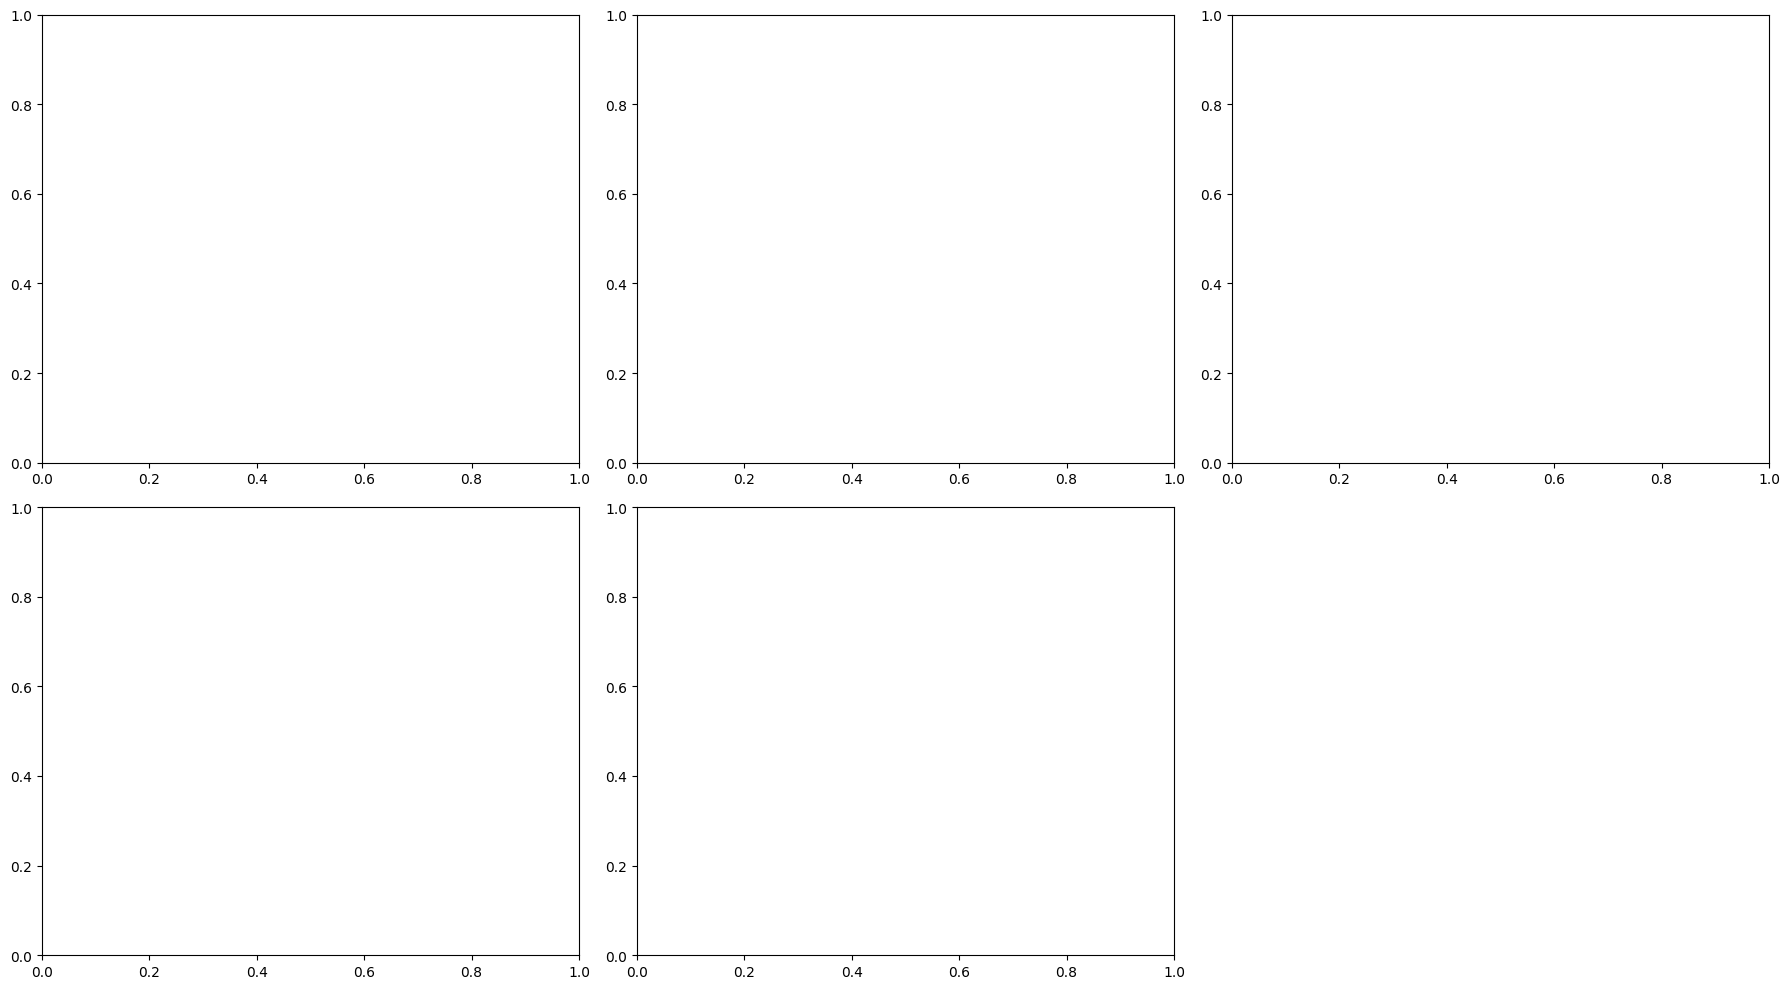

In [20]:
# Configura la griglia in base al numero di modelli
n_models = len(models_info)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

# Garantisci che axs sia 2D anche se c'è solo una riga
axs = axs if n_rows > 1 else [axs]

for i, (model_name, info) in enumerate(models_info.items()):
    row = i // n_cols
    col = i % n_cols

    history = info['history']
    model = info['model']

    if history is not None:
        ax = axs[row][col]
        pd.DataFrame(history.history).plot(ax=ax)
        ax.set_title(f"{model_name}\nParams: {model.count_params():,}")
        ax.grid(True)
        ax.set_ylim(0, 1)

# Nasconde gli assi vuoti, se presenti
for j in range(i + 1, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()


## Loading the test data and running the predictions

In [21]:
imgs = []
labels = []

for label_name in os.listdir(TEST_PATH):
    label_dir = os.path.join(TEST_PATH, label_name)
    if os.path.isdir(label_dir):
        # Cerca immagini dentro la cartella della label
        for img_path in glob.glob(os.path.join(label_dir, '*')):
            imgs.append(img_path)
            labels.append(label_name)

labels = np.array(labels).astype(int)

In [22]:
def get_predictions(model):
    data = []

    for img in imgs:
        image = cv2.imread(img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    X_test = np.array(data)
    X_test = X_test/255
    
    pred = np.argmax(model.predict(X_test), axis=-1)
    return pred, X_test

## Visualizing the confusion matrix

In [23]:
cf = confusion_matrix(labels,  get_predictions(model))
df_cm = pd.DataFrame(cf, index = CLASSES,  columns = CLASSES)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

NameError: name 'confusion_matrix' is not defined

## Classification report

In [ ]:
# Funzione per ottenere le metriche in formato dict
def get_classification_metrics(model, labels):
    y_pred, _ = get_predictions(model)
    report = classification_report(labels, y_pred, output_dict=True, zero_division=0)
    return report

# Modelli da confrontare
models_to_evaluate = {
    'Original': models_info['model']['model'],
    'Improved': models_info['model_imp']['model'],
    'Slim': models_info['model_slim']['model'],
    'MobileNetV2': models_info['model_optimized']['model'],
    'Optimized': models_info['model_mnv2']['model']
}

# Calcola i report per ogni modello
metrics_data = {}

for name, model in models_to_evaluate.items():
    metrics = get_classification_metrics(model, labels)
    # Salviamo solo le medie ('macro avg' e/o 'weighted avg')
    metrics_data[name] = {
        'Precision': metrics['macro avg']['precision'],
        'Recall': metrics['macro avg']['recall'],
        'F1-score': metrics['macro avg']['f1-score'],
        'Accuracy': metrics['accuracy']  # dal report completo
    }

# Crea un DataFrame
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.round(3).T)  # Trasposta per avere modelli come righe


2025-06-07 13:14:41.549463: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109658112 exceeds 10% of free system memory.


70/70 [==============================] - 2s 32ms/step


In [ ]:
print(classification_report(labels, get_predictions(model)[0]))
print(classification_report(labels, get_predictions(model_imp)[0]))
print(classification_report(labels, get_predictions(model_slim)[0]))
print(classification_report(labels, get_predictions(model_mnv2)[0]))
print(classification_report(labels, get_predictions(model_optimized)[0]))

## Visualizing predictions on Test Data

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


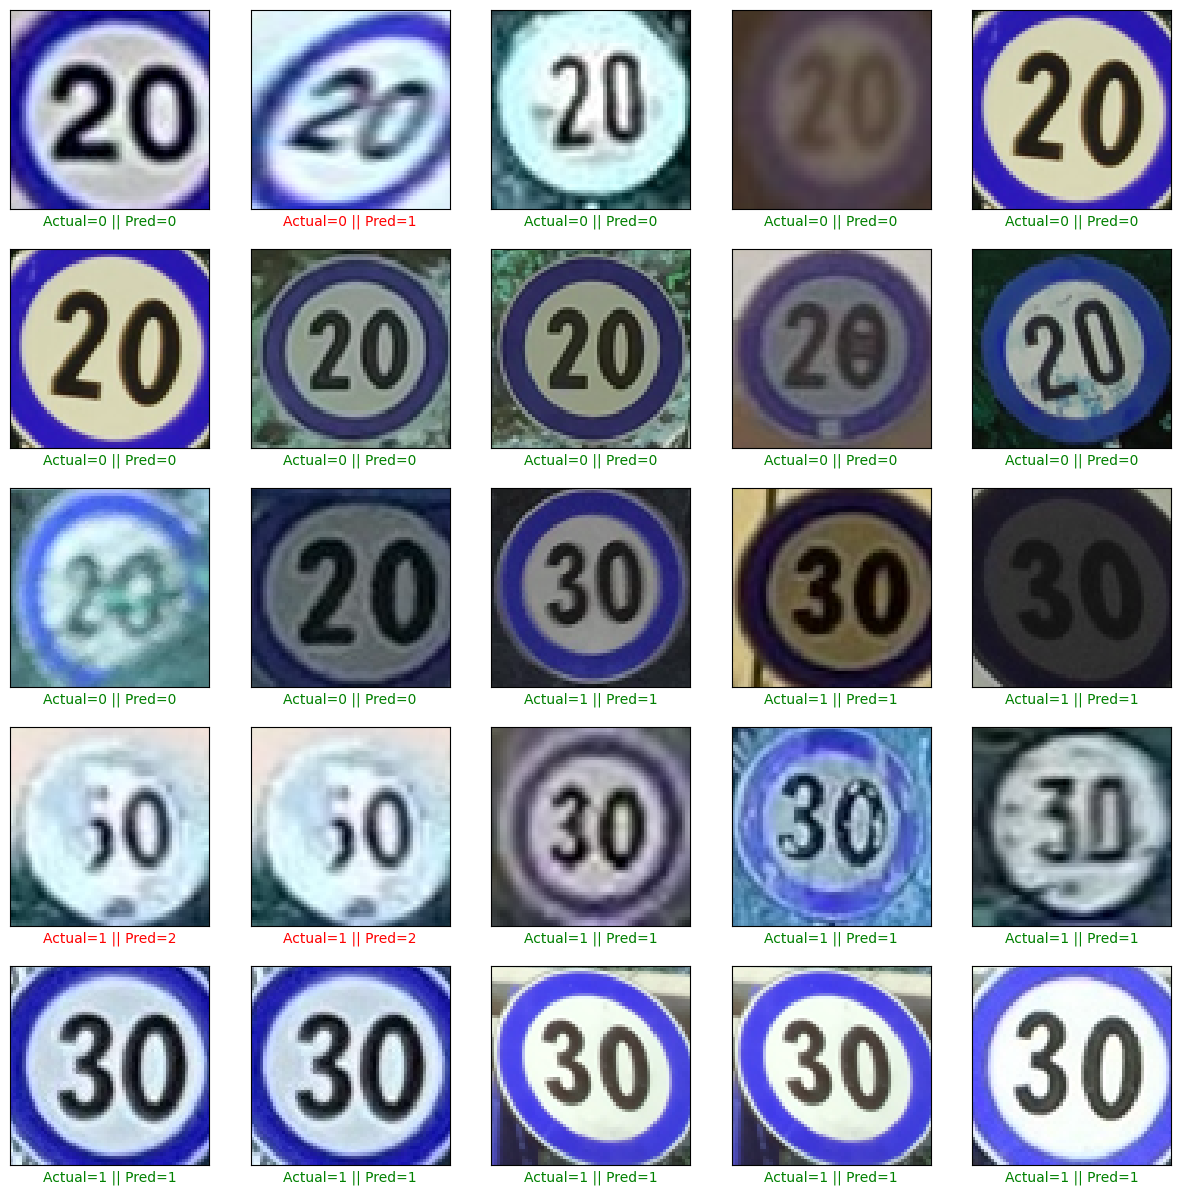

In [47]:
plt.figure(figsize = (15, 15))

pred, X_test = get_predictions(model)

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

# Lime Explainability Evaluation

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 141.70it/s]
/tmp/ipykernel_9/3173386412.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


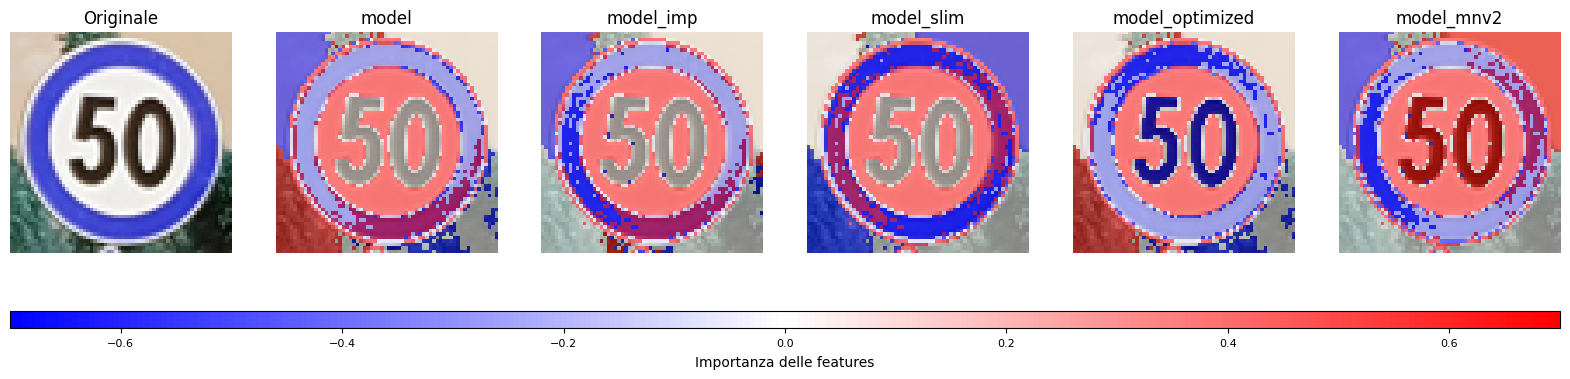

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from lime import lime_image

def predict_fn(images, model):
    # Normalizza tra 0 e 1 come nel training
    batch = np.array([img / 255.0 for img in images])
    return model.predict(batch, verbose=0)

def explain_with_lime(img_array, model):
    explainer = lime_image.LimeImageExplainer(random_state=42)
    return explainer.explain_instance(
        img_array,
        lambda imgs: predict_fn(imgs, model),
        top_labels=1,
        hide_color=1,
        num_samples=300
    )

def generate_overlay(img, explanation, vmin, vmax):
    label = explanation.top_labels[0]
    mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=5,
        hide_rest=False
    )[1]

    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    heatmap = plt.cm.bwr(norm(mask))[..., :3]

    img_norm = img / 255.0
    return 0.5 * img_norm + 0.5 * heatmap

def show_all_results(img_original, blended_list, model_names, vmin, vmax):
    n_models = len(blended_list)
    fig = plt.figure(figsize=(3 * (n_models + 1) + 2, 4.5))
    gs = fig.add_gridspec(2, n_models + 1, height_ratios=[0.95, 0.05], hspace=0.05)

    # Immagine originale
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_original.astype(np.uint8))
    ax0.set_title("Originale")
    ax0.axis('off')

    # Spiegazioni LIME
    for i, (blended, name) in enumerate(zip(blended_list, model_names)):
        ax = fig.add_subplot(gs[0, i + 1])
        ax.imshow(blended)
        ax.set_title(f"{name}")
        ax.axis('off')

    # Colorbar
    cax = fig.add_subplot(gs[1, :])
    sm = cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap='bwr')
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Importanza delle features', labelpad=5)
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

def execute_lime(img_path):
    # Usa il tuo preprocessing
    img_array = process_image(img_path)
    if img_array is None:
        print(f"Immagine non valida: {img_path}")
        return

    img_array = img_array.astype(np.float64)
    blended_list = []
    model_names = []
    masks = []

    for name, info in models_info.items():
        model = info['model']
        explanation = explain_with_lime(img_array, model)
        label = explanation.top_labels[0]
        mask = explanation.get_image_and_mask(
            label,
            positive_only=False,
            num_features=20,
            hide_rest=False
        )[1]
        masks.append(mask)
        model_names.append(name)

    # Normalizzazione coerente
    all_values = np.concatenate([m.flatten() for m in masks])
    abs_max = max(np.abs(all_values.min()), np.abs(all_values.max()))
    vmin = -abs_max * 0.7
    vmax = abs_max * 0.7

    for mask in masks:
        norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
        heatmap = plt.cm.bwr(norm(mask))[..., :3]
        img_norm = img_array / 255.0
        blended = 0.5 * img_norm + 0.5 * heatmap
        blended_list.append(blended)

    show_all_results(img_array, blended_list, model_names, vmin, vmax)

execute_lime(f'{TRAIN_PATH}/02/933778170750252_0.jpg')


# Studio disomogeneità geografiche

In [56]:
def geo_label(lat):
    if lat < 41.5594700:
        return 'sud'
    elif lat > 44.801485:
        return 'nord'
    else:
        return 'centre'

def build_paths(df, base_path='./'):
    return [
        os.path.join(base_path, f"{row['feature_index']:02d}", row['filename'])
        for _, row in df.iterrows()
    ]

def get_predictions_from_paths(model, image_paths):
    data = []
    for img_path in image_paths:
        img = process_image(img_path)
        if img is not None:
            data.append(img)
        else:
            data.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8))
    X = np.array(data, dtype=np.float32) / 255.0
    preds = np.argmax(model.predict(X, verbose=0), axis=-1)
    return preds

# Caricamento metadati e assegnazione area geografica
sign_info = pd.read_parquet(f'{DATA_DIR}/metadata.parquet')
sign_info = sign_info.loc[sign_info['split'] == 'test']
sign_info[['lat', 'lon']] = sign_info['coordinates'].str.split(",", expand=True).astype(float)
sign_info['geo_area'] = sign_info['lat'].apply(geo_label)

area_dfs = {
    'nord': sign_info[sign_info['geo_area'] == 'nord'],
    'centre': sign_info[sign_info['geo_area'] == 'centre'],
    'sud': sign_info[sign_info['geo_area'] == 'sud']
}

# Calcolo metriche per modello e area
accuracy_results = []

for model_name, info in models_info.items():
    model = info['model']
    for area_name, df_area in area_dfs.items():
        image_paths = build_paths(df_area, TEST_PATH)
        preds = get_predictions_from_paths(model, image_paths)
        true_labels = df_area['feature_index'].values

        acc = np.mean(preds == true_labels)
        report = classification_report(true_labels, preds, output_dict=True, zero_division=0)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']

        accuracy_results.append({
            'modello': model_name,
            'area': area_name,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

results_df = pd.DataFrame(accuracy_results)
results_df.pivot(index='modello', columns='area', values='accuracy')

2025-06-07 09:39:23.541085: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 269205504 exceeds 10% of free system memory.
2025-06-07 09:39:33.688761: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 212680704 exceeds 10% of free system memory.
2025-06-07 09:39:43.044926: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268271616 exceeds 10% of free system memory.


area,centre,nord,sud
modello,,,
model,0.999538,0.999452,0.999450
model_imp,0.938757,0.935914,0.940454
model_mnv2,0.998844,0.998905,0.999450
model_optimized,0.997458,0.998357,0.999084
model_slim,0.935521,0.932262,0.938439


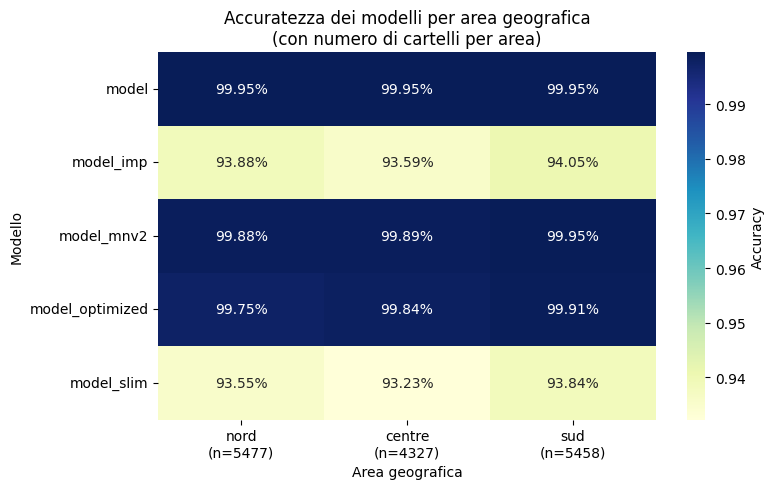

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcolo conteggio cartelli per area
area_counts = {area: len(df) for area, df in area_dfs.items()}

# Pivot per heatmap
heatmap_data = results_df.pivot(index='modello', columns='area', values='accuracy')

# Etichette con numero cartelli da usare come annotazioni o titolo
area_labels = [f"{area}\n(n={count})" for area, count in area_counts.items()]
heatmap_data.columns = area_labels  # aggiorna colonne con annotazioni

# Plot della heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
plt.title("Accuratezza dei modelli per area geografica\n(con numero di cartelli per area)")
plt.xlabel("Area geografica")
plt.ylabel("Modello")
plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# 2. CALCOLO METRICHE DI FAIRNESS
# =============================================================================
fairness_results = []

for model_name in model_dict.keys():
    # Filtra risultati per modello
    model_results = results_df[results_df['modello'] == model_name]
    
    # Estrai metriche per area
    acc_nord = model_results[model_results['area'] == 'nord']['accuracy'].values[0]
    acc_centre = model_results[model_results['area'] == 'centre']['accuracy'].values[0]
    acc_sud = model_results[model_results['area'] == 'sud']['accuracy'].values[0]
    
    rec_nord = model_results[model_results['area'] == 'nord']['recall'].values[0]
    rec_sud = model_results[model_results['area'] == 'sud']['recall'].values[0]
    
    # Calcolo metriche di fairness
    disparate_impact = rec_sud / rec_nord if rec_nord > 0 else np.nan
    equal_opportunity_diff = rec_nord - rec_sud
    accuracy_disparity = max(acc_nord, acc_centre, acc_sud) - min(acc_nord, acc_centre, acc_sud)
    
    fairness_results.append({
        'modello': model_name,
        'disparate_impact': disparate_impact,
        'equal_opportunity_diff': equal_opportunity_diff,
        'accuracy_disparity': accuracy_disparity
    })

fairness_df = pd.DataFrame(fairness_results)

# =============================================================================
# 3. ANALISI CLASSI CRITICHE (LIME INTEGRATO)
# =============================================================================
def analyze_critical_classes(model, area_df, area_name, num_classes=5):
    image_paths = build_paths(area_df, DATA_DIR)
    true_labels = area_df['feature_index'].values
    preds = get_predictions_for_area_study(model, image_paths)
    
    # Calcolo confusion matrix
    cm = confusion_matrix(true_labels, preds)
    
    # Identificazione classi con peggiori performance
    class_errors = {}
    for i in range(len(cm)):
        if np.sum(cm[i]) > 0:  # Evita divisione per zero
            recall = cm[i,i] / np.sum(cm[i])
            class_errors[i] = 1 - recall  # Error rate
    
    # Ordina classi per error rate
    worst_classes = sorted(class_errors.items(), key=lambda x: x[1], reverse=True)[:num_classes]
    
    # Analisi LIME per classi critiche
    lime_insights = []
    for class_id, error_rate in worst_classes:
        # Trova un esempio rappresentativo
        class_examples = area_df[area_df['feature_index'] == class_id]
        if len(class_examples) == 0:
            continue
            
        example = class_examples.iloc[0]
        img_path = os.path.join(DATA_DIR, 'test', f"{example['feature_index']:02d}", example['filename'])
        
        # Genera spiegazione LIME
        img = cv2.imread(img_path)
        img_pil = Image.fromarray(img, mode='RGB').resize((IMG_HEIGHT, IMG_WIDTH))
        img_np = np.array(img_pil)
        
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            img_np, 
            predict_fn_2 if model_name == 'Model_Imp' else predict_fn_3,
            top_labels=5, 
            hide_color=0, 
            num_samples=1000
        )
        
        # Estrai caratteristiche principali
        _, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )
        
        # Calcola copertura delle feature rilevanti
        coverage = np.sum(mask > 0) / mask.size
        
        lime_insights.append({
            'class_id': class_id,
            'class_name': CLASSES[class_id],
            'error_rate': error_rate,
            'feature_coverage': coverage
        })
    
    return lime_insights

# Esegui analisi per ogni modello/area
critical_insights = []
for model_name, mdl in model_dict.items():
    for area_name, df_area in area_dfs.items():
        insights = analyze_critical_classes(mdl, df_area, area_name)
        for insight in insights:
            insight.update({
                'modello': model_name,
                'area': area_name
            })
            critical_insights.append(insight)

critical_df = pd.DataFrame(critical_insights)

# =============================================================================
# 4. VISUALIZZAZIONE RISULTATI
# =============================================================================
plt.figure(figsize=(15, 10))

# Heatmap accuratezza
plt.subplot(2, 2, 1)
heatmap_data = results_df.pivot(index='modello', columns='area', values='accuracy')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title("Accuracy per Area Geografica")
plt.xlabel("")
plt.ylabel("Modello")

# Disparate Impact
plt.subplot(2, 2, 2)
sns.barplot(x='modello', y='disparate_impact', data=fairness_df)
plt.axhline(0.8, color='r', linestyle='--', alpha=0.5)
plt.axhline(1.25, color='r', linestyle='--', alpha=0.5)
plt.title("Disparate Impact (Sud/Nord)")
plt.ylabel("Ratio")
plt.ylim(0, 2)

# Differenziale opportunità
plt.subplot(2, 2, 3)
sns.barplot(x='modello', y='equal_opportunity_diff', data=fairness_df)
plt.axhline(0, color='gray', linestyle='-')
plt.title("Equal Opportunity Difference (Nord - Sud)")
plt.ylabel("Differenziale Recall")

# Feature coverage LIME
plt.subplot(2, 2, 4)
sns.boxplot(x='area', y='feature_coverage', hue='modello', data=critical_df)
plt.title("Copertura Feature Rilevanti (LIME)")
plt.ylabel("Percentuale Copertura")

plt.tight_layout()
plt.show()

# =============================================================================
# 5. REPORTING METRICHE
# =============================================================================
print("\n" + "="*80)
print("ANALISI BIAS GEOGRAFICI - RIEPILOGO")
print("="*80)

for model_name in model_dict.keys():
    model_fairness = fairness_df[fairness_df['modello'] == model_name].iloc[0]
    
    print(f"\n● MODELLO: {model_name}")
    print(f"  - Disparate Impact (Sud/Nord): {model_fairness['disparate_impact']:.3f} [Soglia bias: <0.8 o >1.25]")
    print(f"  - Equal Opportunity Difference: {model_fairness['equal_opportunity_diff']:.3f}")
    print(f"  - Accuracy Disparity: {model_fairness['accuracy_disparity']:.3f}")
    
    # Analisi classi critiche
    model_critical = critical_df[critical_df['modello'] == model_name]
    if not model_critical.empty:
        worst_class = model_critical.loc[model_critical['error_rate'].idxmax()]
        print(f"\n  CLASSE PIÙ CRITICA: {worst_class['class_name']} (ID: {worst_class['class_id']})")
        print(f"  - Area: {worst_class['area']}")
        print(f"  - Error Rate: {worst_class['error_rate']:.2%}")
        print(f"  - Feature Coverage (LIME): {worst_class['feature_coverage']:.2%}")

print("\n" + "="*80)
print("NOTE INTERPRETATIVE:")
print("- Disparate Impact < 0.8 indica possibile svantaggio per il Sud")
print("- Equal Opportunity Difference > 0 indica migliore performance al Nord")
print("- Accuracy Disparity misura la massima differenza tra le aree")
print("- Feature Coverage (LIME) indica quanto l'attenzione del modello è concentrata")
print("="*80)

25/25 [==============================] - 9s 376ms/step


NameError: name 'predict_fn_3' is not defined